## Gerry Chain

run a small Markov Chain to verify data

In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar

In [2]:
import pandas as pd

# Read your shapefile
df = gpd.read_file("./VA/VA.shp")

# List all population columns from your dataset
population_columns = [
    'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
    'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 
    'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'
]

# Replace NaN values with 0 in all population columns
for col in population_columns:
    df[col] = df[col].fillna(0)

In [3]:
graph = Graph.from_geodataframe(df)

/Users/chaoping/miniconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column G18USSD!
  warnings.warn("NA values found in column {}!".format(column))
/Users/chaoping/miniconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column G18USSR!
  warnings.warn("NA values found in column {}!".format(column))


In [4]:
elections = [
    Election("PRE20", {"Democratic": "G20PRED", "Republican": "G20PRER"}),
    Election("SEN20", {"Democratic": "G20USSD", "Republican": "G20USSR"})  
             ]

In [5]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

In [6]:
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [7]:
initial_partition = GeographicPartition(graph, 
                                        assignment= "SEND", 
                                        updaters=my_updaters)

In [8]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [9]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.1,
                   node_repeats=2
                  )

In [10]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [11]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.1)

In [12]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=500
    )

In [13]:
data = pd.DataFrame(
    sorted(partition["SEN20"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

/Users/chaoping/miniconda3/envs/gerry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████| 500/500 [00:01<00:00, 260.74it/s]


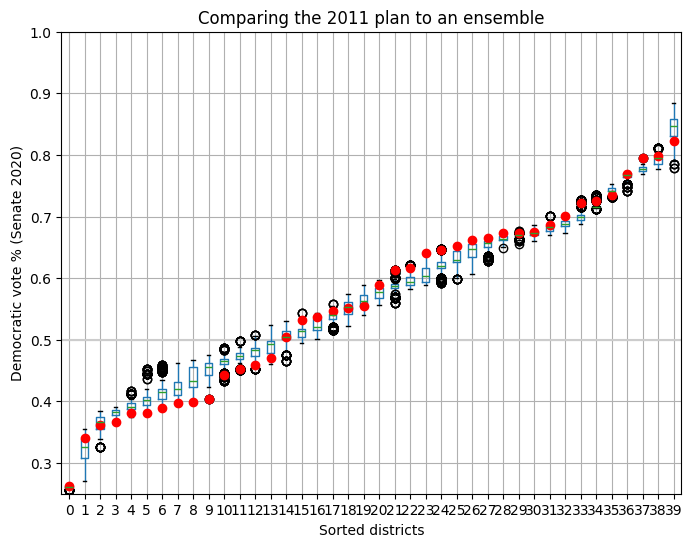

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2020)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [15]:
data = pd.DataFrame(
    sorted(partition["PRE20"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 234.47it/s]


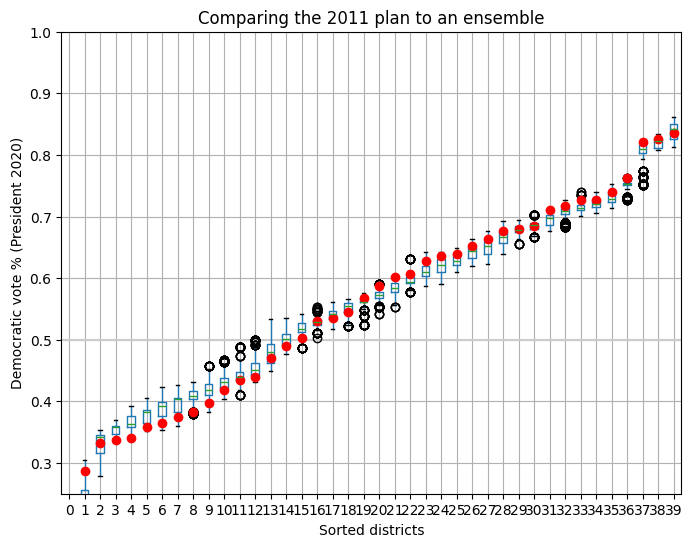

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (President 2020)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()